In [149]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

In [150]:
import numpy as np

# FILL IN YOUR NAME AND THE NAME OF YOUR PEER (IF ANY) BELOW

**Name**: Vahid Danesh

**Peer**: \<replace this with your peer's name\>

## Collaboration policy
Students are responsible for writing their own quizzes, assignments, and exams. For homework assignments, students are welcome (and encouraged) to discuss problems with one peer, **but each student must write their own assignment wrtieup and code individually**. The peer must be listed at the top of the writeup for each assignment. *Note: I will treat AI assistants as peers. That is, students are welcome to discuss problems with an AI assistant, but it is considered cheating to directly obtain an answer by querying the assistant. Please credit any AI assistant that you use.*

# Homework 5 -- Geometric perception (100 pts)

**Due:** Tuesday, March 4th, 2025 at 11:59 pm

This homework builds on the material in the slides, and Tedrake chapter 4 (on Geometric Perception).

We will use Jupyter/Colab notebooks throughout the semester for writing code and generating assignment outputs.

**Throughout this homework, please use 2D numpy arrays to represent all matrices. The autograder will use a precision of 3 decimal places.**


## 1) Understanding point-cloud registration (40 pts)
(Questions from Tedrake Ch 4)

### 1.1) How many points do you need? (15 pts)

Consider the problem of point cloud registration with known correspondences. Points can be directly mapped to corresponding model points to specify the position and orientation of an object in the scene. In most cases, we have far more points than we have decision variables on the object's pose. Therefore, treating each point correspondence as an equality constraint would make the problem over-constrained. This raises a natural question:

What is the minimum number of points that can uniquely specify the pose of an object in 2D? 

_Points:_ 7.5

In [151]:
# Provide your answer as a scalar integer
ans_111 = 2

What is the minimum number of points that can uniquely specify the pose of an object in 3D? 

_Points:_ 7.5

In [152]:
# Provide your answer as a scalar integer
ans_112 = 3

### 1.2) Point registration with fixed rotation (25 pts)

Consider the case of point registration with known correspondences where the rotation component of $X^O$ is known, but not the translation.

Specifically, say your scene points ${}^W X^C \cdot {}^{C} p^{s_i} = {}^W p^{s_i}$ are defined as follows:
$$\begin{aligned}
{}^W p^{s_0} &= (1,5)\\
{}^W p^{s_1} &= (3,10)\\
{}^W p^{s_2} &= (5,10)\enspace,
\end{aligned}$$

which can be plotted as follows:

<img src="https://jorge-a-mendez.github.io/images/ese564s24/12_scenepoints.png" width="20%">

And your scene points are defined as follows:
$$\begin{aligned}
{}^O p^{m_0} &= (-2, -5)\\
{}^O p^{m_1} &= (0,0)\\
{}^O p^{m_2} &= (0,0)\enspace,
\end{aligned}$$

which can be plotted as follows:

<img src="https://jorge-a-mendez.github.io/images/ese564s24/12_modelpoints.png" width="20%">

As you can see, both triangles are in the same orientation, so $R^O=\begin{bmatrix}1&0\\0&1\end{bmatrix}$. However, we still need to solve for the translation component of $X^O$. 


### 1.2.1) 

Using the objective $\sum_{i=0}^n\| ^{W} p^{m_i} - {}^W p^{s_i}\|^2$, what is the value of the objective function for $p^{O} = (0,0)$?

_Points:_ 3

In [153]:
# Provide your answer as a scalar 
ans_121 = 327

### 1.2.2) 

What is the value of the objective function for $p^{O} = (3, 10)$?

_Points:_ 3

In [154]:
# Provide your answer as a scalar 
ans_122 = 0

### 1.2.3) 

What is the value of the objective function for $p^{O} = (6,12)$?

_Points:_ 3

In [155]:
# Provide your answer as a scalar 
ans_123 = 39

### 1.2.4) 

Now consider the general case, with known correspondences, fixed $R^O=I_{2\times2}$, and equal number of scene and model points, but where it may not be possible to perfectly align the scene and model points (e.g., due to noise or modeling error). Determine what the translational component should be and write a Python function that finds this solution.

_Points:_ 16

In [156]:
def transform_translation_214(p_Om, p_s):
    """
    Find the optimal translation vector p^O that minimizes the sum of square distances
    p_Om: np.ndarray of shape (n, 2) representing the coordinates of the model points in the original object frame
    p_s: np.ndarray of shape (n, 2) representing the coordinates of the scene points in the world frame
    return: np.ndarray of shape (2,) representing the optimal translation vector
    """
    p_O = np.mean(p_s - p_Om, axis=0)
    return p_O

## 2) Point-cloud registration (60 pts)

We are going to write a full implementation of the ICP algorithm, and then apply it to a few data sets. To help with debugging, I have provided the following visualization function that takes as input a model point cloud, a scene point cloud, a rotation and a translation, and visualizes the transformed model point cloud and the scene point cloud.

Of note, this function uses a common Numpy trick, which is to apply a matrix operation on a _collection_ of points by stacking all points in a tall matrix. Since we use tall matrices (n, d), we need to _right_ multiply by the rotation matrix. When doing right-multiplication, we need to transpose the rotation matrix to achieve the correct result. *I encourage you to verify that this is correct by hand.*

See subsequent code cells for example use of the visualization code. 

In [157]:
import matplotlib.pyplot as plt

def visualize_point_clouds(p_Om, p_s, R, p):
    """
    Visualize the model and scene point clouds after applying the transformation
    p_Om: np.ndarray of shape (n, d) representing the coordinates of the model points in the original object frame
    p_s: np.ndarray of shape (n, d) representing the coordinates of the scene points in the world frame
    R: np.ndarray of shape (d, d) representing the rotation matrix
    p: np.ndarray of shape (d,) representing the translation vector
    
    d must be 2 or 3
    """
    _, d = p_Om.shape
    if d not in (2, 3):
        raise ValueError("d must be 2 or 3")
    p_O = np.dot(p_Om, R.T) + p 
    if d == 2:
        plt.scatter(p_O[:, 0], p_O[:, 1], label='Model')
        plt.scatter(p_s[:, 0], p_s[:, 1], label='Scene')
    else:
        ax = plt.axes(projection='3d')
        ax.scatter3D(p_O[:, 0], p_O[:, 1], p_O[:, 2], label='Model')
        ax.scatter3D(p_s[:, 0], p_s[:, 1], p_s[:, 2], label='Scene')
        # Label the x,y,z axes
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    plt.legend()
    plt.show()

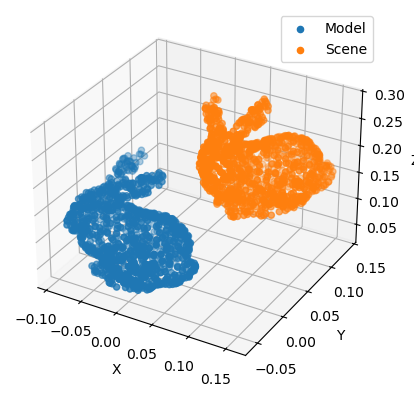

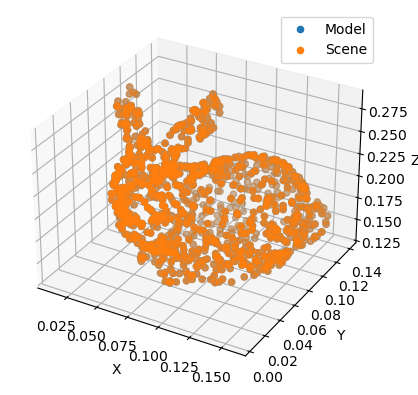

In [158]:
# load stanford_bunny.npy
stanford_bunny = np.load('stanford_bunny.npy')

# Rotate by 45 degrees about the z-axis
R = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4), 0], [np.sin(np.pi/4), np.cos(np.pi/4), 0], [0, 0, 1]])

# Translate by (0.5, 0.5, 1)
p = np.array([0.1, 0.1, 0.1])

stanford_bunny_scene = np.dot(stanford_bunny, R.T) + p

# Show the original and transformed point clouds
visualize_point_clouds(stanford_bunny, stanford_bunny_scene, np.eye(3), np.zeros(3))

# Show the original and corrected point clouds
visualize_point_clouds(stanford_bunny, stanford_bunny_scene, R, p)

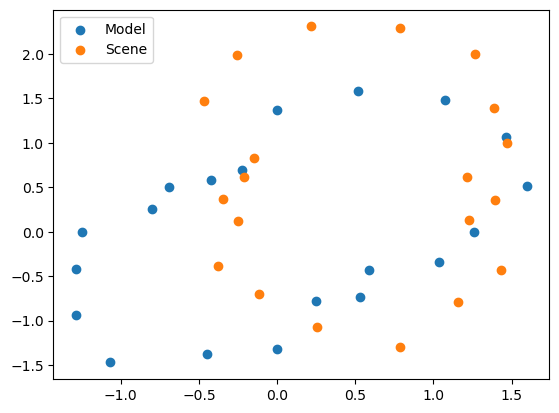

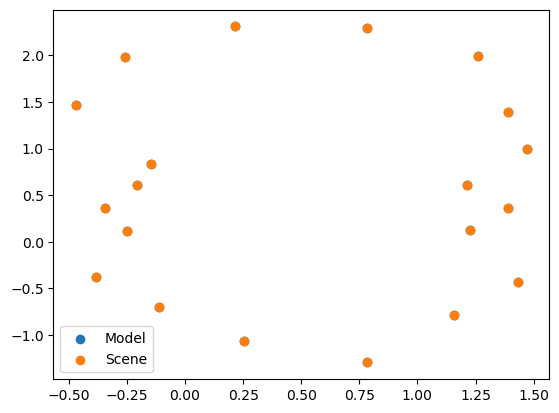

In [159]:
# load random_2d.npy

#
random_2d = np.load('random_2d.npy')

# Rotate by 45 degrees 
R = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)], [np.sin(np.pi/4), np.cos(np.pi/4)]])

# Translate by (0.5, 0.5)
p = np.array([0.5, 0.5])

random_2d_scene = np.dot(random_2d, R.T) + p

# Show the original and transformed point clouds
visualize_point_clouds(random_2d, random_2d_scene, np.eye(2), np.zeros(2)) 

# Show the original and corrected point clouds
visualize_point_clouds(random_2d, random_2d_scene, R, p)


### 2.1) Rotation from known correspondences

The first step in implementing ICP is to find the rotation of the model points assuming known correspondences. The algorithm is simple:
1. Find the centroids ${}^O p^{\bar{m}}=\frac{1}{n}\sum_{i=0}^{n-1}{}^O p^{m_i}$ and $p^{\bar{s}}=\frac{1}{n}\sum_{i=0}^{n-1} p^{s_i}$
2. Construct the data matrix $W=\sum_{i=0}^{n-1} (p^{s_i} - p^{\bar{s}})({}^O p^{m_i} - {}^Op^{\bar{m}})^\top$
3. Solve SVD: $W = U\Sigma V^\top$
4. Replace $\Sigma$ by $D=\mathrm{diag}(1, 1, \det UV^\top)$ and set $R= UDV^\top$

*Hint 1: to help keep your implementation clean, it may help to think about how you could write $\sum_{i=0}^{n-1} (a^i)(b^i)^\top$, where $a^i$ and $b^i$ are column vectors, in terms of tall matrices $A$ and $B$ whose rows are the (transposed) $a^i$'s and $b^i$'s respectively.*

*Hint 2: look at the `np.linalg.svd` function, and be sure to carefully examine what values it returns.*

_Points:_ 12

In [160]:
def find_R_from_ordered_points_21(p_Om, p_s):
    """
    Find the rotation matrix R that best aligns the points in p_m to the points in p_s.
    p_Om: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    p_s: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    Return: a 2D numpy array of shape (d, d) representing the rotation matrix R.

    Assumes that the points in p_Om and p_s are ordered such that p_Om[i] corresponds to p_s[i]
    """
    p_Om_mean = np.mean(p_Om, axis=0)
    p_s_mean = np.mean(p_s, axis=0)
    p_Om_centered = p_Om - p_Om_mean
    p_s_centered = p_s - p_s_mean

    W = np.dot(p_s_centered.T, p_Om_centered)
    U, _, Vt = np.linalg.svd(W)
    d = np.linalg.det(np.dot(U, Vt))
    D = np.eye(U.shape[0])
    D[-1, -1] = d
    R = np.dot(U, np.dot(D, Vt))    
    
    return R

### 2.2) Translation from known correspondences

The next step is to find the translation component of the transform, given the known correspondences and the rotation computed in the previous step. This is given simply by:

$$p = p^{\bar{s}} - R \cdot {}^O p ^{\bar{m}}$$

_Points:_ 12

In [161]:
def find_p_from_ordered_points_22(R, p_Om, p_s):
    """
    Find the translation vector p that best aligns the points in p_m to the points in p_s.
    R: a 2D numpy array of shape (d, d) representing the rotation matrix.
    p_m: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    p_s: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    Return: a 1D numpy array of shape (d,) representing the translation vector p.

    Assumes that the points in p_m and p_s are ordered such that p_m[i] corresponds to p_s[i]
    """
    
    
    # Compute the translation vector
    p = np.mean(p_s, axis=0) - np.dot(R, np.mean(p_Om, axis=0))

    return p

### 2.3) Finding the correspondence vector

The steps in 2.1 and 2.2 find the optimal transform given a collection of model points $^O p^{m_i}$ and scene points $p^{s_i}$, assuming that the correspondence between them is known. In particular, they assume that The correspondence is between the $i$-th model point and the $i$-th scene point.

Realistically, these correspondences are not given. ICP works by iteratively finding the best correspondences given a current guess of the transform, and then the best transform given the current guess of the correspondences.

Let's start by implementing a function that finds the correspondence vector between model and scene points for a given transformation given by $R^O, p^O$. The function should find, for each scene point $i$, what is the index $j$ of the model point $m_j$ that is closest to $s_i$ after applying the transform: $p^{m_j} = X^O \cdot {}^O p^{m_j}$. 

*Hint: there is a clever way to us Numpy broadcasting to compute all distances in a single function call. It is not mandatory to use this, but it will make your implementation cleaner.*

*Hint 2: note that this function must work for point clouds of different sizes m and n.*

_Points:_ 12

In [162]:
def find_correspondence_vector_23(p_Om, p_s, R_O, p_O):
    """
    Find the closest point in p_m for each point in p_s.
    p_m: a 2D numpy array of shape (m, d) where m is the number of points and d is the dimension of the points (2 or 3).
    p_s: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    R_O: a 2D numpy array of shape (d, d) representing the rotation matrix.
    p_O: a 1D numpy array of shape (d,) representing the translation vector.
    Return: a 1D numpy array of shape (n,) containing the index of the closest point in p_m for each point p_s[i].
    """
    # Compute the transformed model points
    p_Om = np.dot(p_Om, R_O.T) + p_O

    # Compute the Euclidean distance between each scene point and each model point
    distances = np.linalg.norm(p_s[:, np.newaxis, :] - p_Om, axis=2)

    # Find the index of the closest model point for each scene point
    correspondences = np.argmin(distances, axis=1)
    

    return correspondences

### 2.4) ICP: putting it all together

We now have all the pieces required to implement ICP. The algorithm starts from an initial guess $X^{O_0}$, uses that to compute the correspondences, finds the optimal transform $X^{O_1}$, and repeats this process until convergence. 

Implement this algorithm using your functions from 2.1 -- 2.3. As your convergence criterion, check whether the previous correspondences and the new correspondences exactly match. (At that point, would it be possible for the algorithm to make any further progress?)

*Hint: think about how to leverage the correspondence vector found in the previous step to produce inputs that have the correct correspondences as expected by your functions to find rotation and translation.*

_Points:_ 12

In [163]:
def iterative_closest_points_24(p_Om, p_s, R_O0, p_O0):
    """
    Find the rigid transformation that best aligns the points in p_Om to the points in p_s.
    p_Om: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    p_s: a 2D numpy array of shape (n, d) where n is the number of points and d is the dimension of the points (2 or 3).
    R_O0: a 2D numpy array of shape (d, d) representing the initial guess of the rotation matrix.
    p_O0: a 1D numpy array of shape (d,) representing the initial guess of the translation vector.
    Return: a tuple containing the rotation matrix R and translation vector p that best aligns the points in p_Om to the points in p_s.

    Does not assume knowledge about the correspondence between points in p_Om and p_s.
    """

    R_O = R_O0
    p_O = p_O0
    corr = np.zeros(p_Om.shape[0], dtype=int)
    

    while True:
        corr_prev = corr 
        corr = find_correspondence_vector_23(p_Om, p_s, R_O, p_O)
        R_O = find_R_from_ordered_points_21(p_Om[corr], p_s)
        p_O = find_p_from_ordered_points_22(R_O, p_Om[corr], p_s)
       

        if np.array_equal(corr, corr_prev):
            return R_O, p_O



### 2.5) Analyzing the behavior of ICP

The following questions will have you analyze the behavior of ICP on various point-clouds and with various initial guesses. You are encouraged to work on this question once you have finalized (and obtained credit for) questions 2.1--2.5. 

Note: your code for the following questions will not be evaluated. You will use it to analyze how ICP is working, and the evaluation will be based on your answers to the questions below.

### 2.5.1) Poor initialization

The following code cell runs your ICP code on a pair of point clouds, `random_2d.npy` and `random_2d_scene.npy`. There are no outliers or partial views: the two point clouds only differ in their poses. It starts from a fixed initial guess `R_O0, p_O0`. Run the code and observe the resulting point-clouds. Which of the following are true about ICP on this point-cloud? Choose all that apply

a. ICP does not converge\
b. ICP gets stuck in a local optimum\
c. ICP finds a solution that has higher cost than the optimal solution\
d. The rotation matrix `R_O` obtained by ICP is far from the true rotation\
e. The translation vector `p_O` obtained by ICP is far from the true translation vector\
f. The correspondences found by ICP are far from the true correspondences

_Points:_ 3

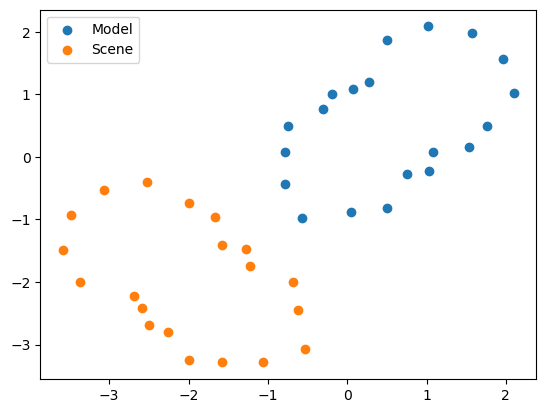

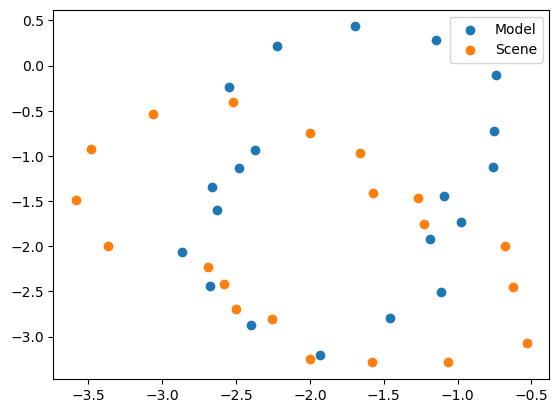

In [164]:
import numpy as np
model_points = np.load('random_2d.npy')
scene_points = np.load('random_2d_scene.npy')
theta = 0#-np.pi/4
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
p = np.array([0.5, 0.5])

# Visualize the point clouds aligned by the initial guess R, p
visualize_point_clouds(model_points, scene_points, R, p)

R_icp, p_icp = iterative_closest_points_24(model_points, scene_points, R, p)
# Visualize the point clouds aligned by the ICP solution R_icp, p_icp
visualize_point_clouds(model_points, scene_points, R_icp, p_icp)

In [165]:
# Express your answer as a list containing each chosen option as a lower-case string (e.g., ["a", "b"] for a and b, or [] for none)
ans_251 = ["b", "c", "d", "f"]


Because ICP is sensitive to the choice of initialization, it is common practice to attempt multiple initializations and return the one with lowest error. To understand why this is useful, the following questions will have you run ICP on various choices of initialization.

The following code cell contains code to generate a random 2D poses.

In [166]:
def random_2d_pose(min_xy=-3, max_xy=-2):
    theta = np.random.rand() * 2 * np.pi
    p = np.random.rand(2) * (max_xy - min_xy) + min_xy
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return R, p

### 2.5.2) Symmetric objects

The following code cell loads two point clouds, `symmetric_2d.npy` and `symmetric_scene_2d.npy`, without outliers or partial views. Use the code cell to run ICP multiple times on random initializations; be sure to visualize the point clouds and observe the returned rotation and translation. Which of the following are true about ICP on this point-cloud? Choose all that apply.

a. For some initializations, ICP does not converge\
b. ICP does not converge for any initialization\
c. For some initializations, ICP gets stuck in a "bad" local optimum\
d. For all initializations, ICP gets stuck in a "bad" local optimum\
e. For all initializations, ICP finds the same (or a very similar) rotation matrix `R_O`\
f. For all initializations, ICP finds the same (or a very similar) translation vector `p_O`\
g. For all initializations, ICP finds the same (or a very similar) correspondence vector



_Points:_ 3

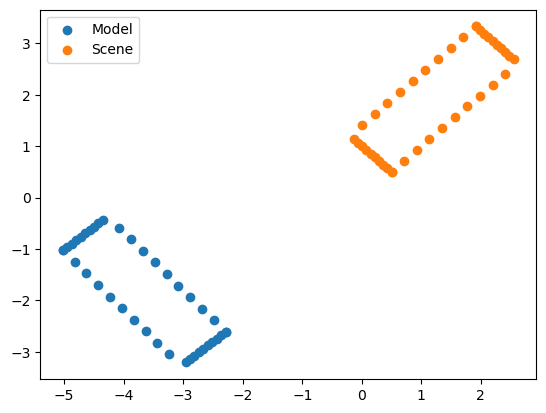

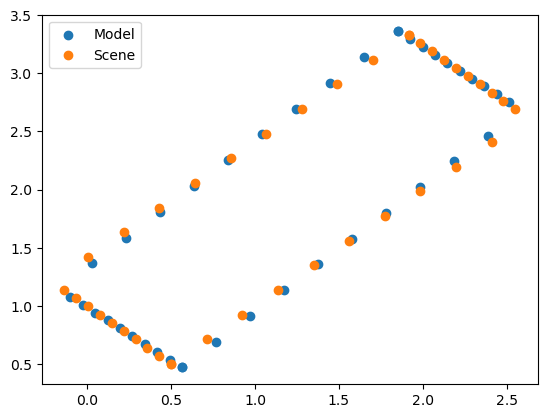

In [167]:
model_points = np.load('symmetric_2d.npy')
scene_points = np.load('symmetric_2d_scene.npy')

R, p = random_2d_pose()
visualize_point_clouds(model_points, scene_points, R, p)
R_icp, p_icp = iterative_closest_points_24(model_points, scene_points, R, p)
visualize_point_clouds(model_points, scene_points, R_icp, p_icp)

In [168]:
# Express your answer as a list containing each chosen option as a lower-case string (e.g., ["a", "b"] for a and b, or [] for none)
ans_252 = []

### 2.5.3) Partial views

The following code cell loads two point clouds, `random_2d.npy` and `random_2d_scene_partial.npy`, where the `scene` point cloud is a partial view of the (rotated and translated) model point cloud. Use the code cell to run ICP multiple times on random initializations; be sure to visualize the point clouds and observe the returned rotation and translation. Which of the following are true about ICP on this point-cloud? Choose all that apply. *Hint: make sure to run ICP many times*

a. For some initializations, ICP does not converge\
b. ICP does not converge for any initialization\
c. For some initializations, ICP gets stuck in a "bad" local optimum\
d. For all initializations, ICP gets stuck in a "bad" local optimum\
e. For all initializations, ICP finds the same (or a very similar) rotation matrix `R_O`\
f. For all initializations, ICP finds the same (or a very similar) translation vector `p_O`\
g. For all initializations, ICP finds the same (or a very similar) correspondence vector



_Points:_ 3

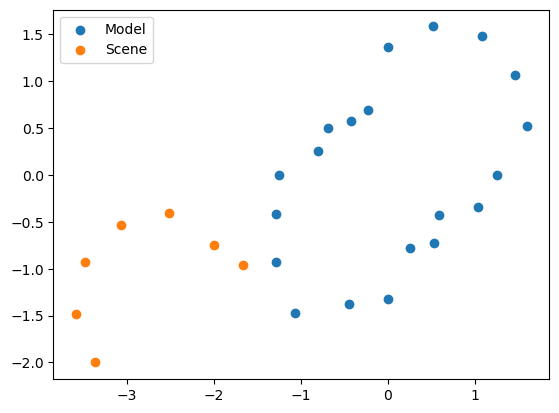

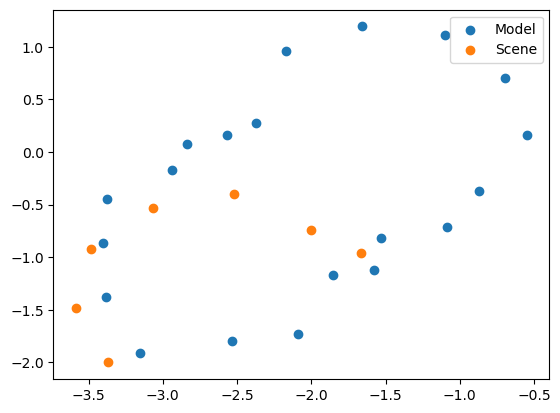

In [169]:
model_points = np.load('random_2d.npy')
scene_points = np.load('random_2d_scene_partial.npy')

R_1 = np.identity(2)
p_1 = np.array([0, 0])

visualize_point_clouds(model_points, scene_points, R_1, p_1)

R_icp, p_icp = iterative_closest_points_24(model_points, scene_points, R_1, p_1)
visualize_point_clouds(model_points, scene_points, R_icp, p_icp)

In [170]:
# Express your answer as a list containing each chosen option as a lower-case string (e.g., ["a", "b"] for a and b, or [] for none)
ans_253 = ['c']


### 2.5.4) Outliers

The following code cell loads two point clouds, `random_2d.npy` and `random_2d_scene_outliers.npy`, where the `scene` point cloud is full view of the (rotated and translated) model point cloud with some additional outliers. Use the code cell to run ICP multiple times on random initializations; be sure to visualize the point clouds and observe the returned rotation and translation. Which of the following are true about ICP on this point-cloud? Choose all that apply. 

a. For some initializations, ICP finds a solution that is shifted toward the outliers\
b. For all initializations, ICP finds a solution that is shifted toward the outliers\
c. For some initializations, ICP gets stuck in a "bad" local optimum\
d. For all initializations, ICP gets stuck in a "bad" local optimum\
e. For all initializations, ICP finds the same (or a very similar) rotation matrix `R_O`\
f. For all initializations, ICP finds the same (or a very similar) translation vector `p_O`\
g. For all initializations, ICP finds the same (or a very similar) correspondence vector\


_Points:_ 3

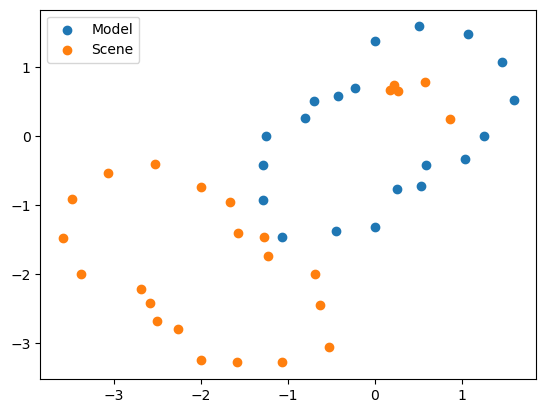

In [ ]:
model_points = np.load('random_2d.npy')
scene_points = np.load('random_2d_scene_outliers.npy')


visualize_point_clouds(model_points, scene_points, R_1, p_1)

R_icp, p_icp = iterative_closest_points_24(model_points, scene_points, R_1, p_1)
visualize_point_clouds(model_points, scene_points, R_icp, p_icp)

In [147]:
# Express your answer as a list containing each chosen option as a lower-case string (e.g., ["a", "b"] for a and b, or [] for none)
ans_254 = ["b", "c"]

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Fill out the answers to all questions and submit your file hw5.ipynb to the HW5 assignment on Gradescope. You are free to resubmit as many times as you wish.

In [148]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:


